## Environment Setup

Libraries for:
- Data processing and manipulation
- LLM access and fine-tuning
- Evaluation metrics
- Hugging Face integration for dataset upload and model download

In [ ]:
# Install necessary dependencies
!pip install -q transformers datasets evaluate peft bitsandbytes accelerate
!pip install -q huggingface_hub
!pip install -q trl
!pip install -q nltk rouge-score sacrebleu
import getpass
# Optional: For specific use cases
# !pip install -q sentencepiece tokenizers
# !pip install -q gradio # For demo creation

# Login to Hugging Face (you'll need a token)
from huggingface_hub import login
# Uncomment the line below and add your token when ready to upload datasets
HF_TOKEN = getpass.getpass("Hugging Face Token: ")
login(HF_TOKEN)

# Verify installations
import transformers
import datasets
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Datasets version: {datasets.__version__}")
print(f"PEFT version: {peft.__version__}")

# Check available GPU
!nvidia-smi
# ideally a T4 or A100 GPU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34

## Synthetic Data Generation

Synthetic dataset generation of marine biology Q&A pairs using the Gemini 2.0 Flash model via the google.genai API.

- Topics are predefined (~50 marine biology subtopics).
- A prompt-based method is used to generate 20 high-quality question-answer pairs per topic.
- The Gemini API is accessed securely using getpass.getpass() to avoid exposing the API key.
- Responses are parsed to extract clean, structured Q&A pairs.
- The final dataset is saved as marine_biology_qa_dataset_gemini.csv.  

Dataset: https://huggingface.co/datasets/enigma04/marine-biology-qna-dataset

In [ ]:
from google import genai
import pandas as pd
from datasets import Dataset
from tqdm.auto import tqdm
import time
import getpass

api_key = getpass.getpass("Gemini API key: ")

client = genai.Client(api_key=api_key)

subtopics = [
    "Marine Ecosystems", "Coral Reef Ecology", "Mangrove Forests", "Kelp Forests", "Estuarine Dynamics",
    "Deep Sea Adaptations", "Hydrothermal Vents", "Abyssal Plain Fauna", "Polar Ocean Ecosystems", "Open Ocean Ecology",
    "Marine Mammals", "Cetacean Communication", "Pinniped Behavior", "Marine Birds", "Shark and Ray Biology",
    "Plankton Ecology", "Zooplankton vs Phytoplankton", "Diatoms and Dinoflagellates", "Jellyfish Blooms", "Marine Food Webs",
    "Ocean Currents", "Thermohaline Circulation", "El Niño and La Niña", "Upwelling Systems", "Ocean Acidification",
    "Marine Conservation", "MPAs (Marine Protected Areas)", "Overfishing", "Bycatch Reduction", "Coral Bleaching",
    "Photosynthesis in Algae", "Seaweed Farming", "Bioluminescence", "Symbiosis in the Sea", "Predator-Prey Interactions",
    "Marine Toxins", "Plastic Pollution", "Oil Spills Impact", "Noise Pollution", "Microplastics in Food Chains",
    "Marine Biotechnology", "Bioprospecting in Oceans", "Marine Genetics", "DNA Barcoding of Species", "Fisheries Management",
    "Ocean Exploration", "ROVs and Submersibles", "Marine Data Collection", "Climate Change and Oceans", "Seafloor Mapping"
]

def generate_prompt(topic, num_pairs):
    return (
        f"Generate exactly {num_pairs} unique, high-quality factual question-answer pairs about the marine biology topic: '{topic}'. "
        "Requirements:\n"
        "- Questions should be clear, specific, and at undergraduate level\n"
        "- Answers should be 2-4 sentences, factually accurate, and scientifically precise\n"
        "- Include diverse question types such as definitions, explanations of biological processes, real-world applications, and cause-effect questions\n"
        "- Ensure a balanced variety of question types\n"
        "- Avoid yes/no questions; prefer 'what', 'how', 'why', 'where' questions\n"
        "- Avoid ambiguous or overly broad questions; each should be precise and focused\n"
        "- Use proper scientific terminology\n"
        "- Ensure answers are supported by widely accepted scientific knowledge\n"
        "- Double-check that all questions and answers are relevant specifically to '{topic}'\n\n"
        f"Format exactly as:\n" +
        "\n".join([f"Q{i+1}: [question]\nA{i+1}: [answer]" for i in range(num_pairs)])
    )

def generate_text_gemini(prompt):
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[prompt]
    )
    return response.text

def parse_response(text, topic):
    lines = [line.strip() for line in text.split("\n") if line.strip()]
    pairs = []
    for i in range(0, len(lines) - 1, 2):
        if lines[i].startswith("Q") and lines[i+1].startswith("A"):
            question = lines[i].split(":", 1)[1].strip()
            answer = lines[i+1].split(":", 1)[1].strip()
            if len(question) > 10 and len(answer) > 20:
                pairs.append({"topic": topic, "question": question, "answer": answer})
    return pairs

def show_quality_stats(df):
    print(f"\n=== DATASET SUMMARY ===")
    print(f"Total Q&A pairs: {len(df)}")
    print(f"Topics covered: {df['topic'].nunique()}")
    print(f"\n=== SAMPLE DATA ===")
    sample = df.head(2)
    for _, row in sample.iterrows():
        print(f"Topic: {row['topic']}")
        print(f"Q: {row['question']}")
        print(f"A: {row['answer'][:100]}...")
        print("-" * 50)

print("Generating marine biology Q&A dataset using Gemini API...")

all_pairs = []

for topic in tqdm(subtopics, desc="Processing topics"):
    print(f"\nProcessing topic: '{topic}'")
    topic_pairs = []
    retries = 3
    while len(topic_pairs) < 20 and retries > 0:
        remaining = 20 - len(topic_pairs)
        prompt = generate_prompt(topic, remaining)
        try:
            response_text = generate_text_gemini(prompt)
            new_pairs = parse_response(response_text, topic)

            existing_qs = {pair['question'] for pair in topic_pairs}
            new_unique_pairs = [pair for pair in new_pairs if pair['question'] not in existing_qs]

            topic_pairs.extend(new_unique_pairs)
            print(f"Collected {len(topic_pairs)} pairs so far for '{topic}'...")
        except Exception as e:
            print(f"Error for '{topic}': {e}")
        retries -= 1
        time.sleep(1)

    if len(topic_pairs) < 20:
        print(f"Warning: Only {len(topic_pairs)} pairs generated for '{topic}' after retries.")
    all_pairs.extend(topic_pairs[:20])

if all_pairs:
    df = pd.DataFrame(all_pairs)
    show_quality_stats(df)
    df.to_csv("marine_biology_qa_dataset_gemini.csv", index=False)
    print("Dataset saved as 'marine_biology_qa_dataset_gemini.csv'")
else:
    print("No data generated. Check API key and parameters.")

Gemini API key: ··········
Generating marine biology Q&A dataset using Gemini API...


Processing topics:   0%|          | 0/50 [00:00<?, ?it/s]


Processing topic: 'Marine Ecosystems'
Collected 20 pairs so far for 'Marine Ecosystems'...

Processing topic: 'Coral Reef Ecology'
Collected 20 pairs so far for 'Coral Reef Ecology'...

Processing topic: 'Mangrove Forests'
Collected 20 pairs so far for 'Mangrove Forests'...

Processing topic: 'Kelp Forests'
Collected 20 pairs so far for 'Kelp Forests'...

Processing topic: 'Estuarine Dynamics'
Collected 20 pairs so far for 'Estuarine Dynamics'...

Processing topic: 'Deep Sea Adaptations'
Collected 20 pairs so far for 'Deep Sea Adaptations'...

Processing topic: 'Hydrothermal Vents'
Collected 20 pairs so far for 'Hydrothermal Vents'...

Processing topic: 'Abyssal Plain Fauna'
Collected 20 pairs so far for 'Abyssal Plain Fauna'...

Processing topic: 'Polar Ocean Ecosystems'
Collected 20 pairs so far for 'Polar Ocean Ecosystems'...

Processing topic: 'Open Ocean Ecology'
Collected 20 pairs so far for 'Open Ocean Ecology'...

Processing topic: 'Marine Mammals'
Collected 20 pairs so far fo

In [ ]:
def upload_dataset_to_hf():
    # Load the CSV dataset
    dataset = Dataset.from_csv("marine_biology_qa_dataset_gemini.csv")

    # Push to Hugging Face Hub
    dataset.push_to_hub(
        "enigma04/marine-biology-qna-dataset",
    )
    print("Dataset uploaded to Hugging Face")

upload_dataset_to_hf()

Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset uploaded to Hugging Face


## Model Fine-tuning

Fine-tune the `TinyLlama-1.1B-Chat-v1.0` model using **Parameter-Efficient Fine-Tuning (PEFT)** with **LoRA** and **4-bit quantization** for low-resource adaptation.

### Why TinyLlama-1.1B-Chat-v1.0?

`TinyLlama-1.1B-Chat-v1.0`, a compact open-weight model with just **1.1B parameters**, is well-suited for fine-tuning in constrained environments (e.g., Colab, single GPU setups, consumer hardware). It shares the **same architecture and tokenizer as LLaMA 2**, ensuring compatibility with existing tools.

This specific chat version was:
- Initially fine-tuned on a variant of the **UltraChat** dataset (synthetic multi-turn dialogues)
- Further aligned using **Direct Preference Optimization** on the **UltraFeedback** dataset  
- Designed for chatbot-style, instruction-following environments

Model card: [TinyLlama](https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0)

### Summary of Workflow:
- Load a 4-bit quantized version of the model using `BitsAndBytesConfig`
- Format dataset for **instruction fine-tuning** using `<|user|>` and `<|assistant|>` tokens
- Apply **LoRA adapters** to specific transformer layers
- Train using Hugging Face `Trainer` with gradient checkpointing
- Save the fine-tuned model and tokenizer locally

---

### 4-bit Quantization (`BitsAndBytesConfig`)
```python
BitsAndBytesConfig(
    load_in_4bit=True,                   # Loads weights in 4-bit to reduce memory usage
    bnb_4bit_compute_dtype=torch.float16 # Computation done in float16 for efficiency
)
```
- Reduces GPU memory footprint  
- Enables training large models on GPUs like T4/Colab

---

### LoRA Adapter Configuration (`LoraConfig`)
```python
LoraConfig(
    r=16,                        # Rank of LoRA update matrices (controls capacity of adaptation)
    lora_alpha=32,               # Scaling factor for the updates
    target_modules=[             # Inject LoRA into specific layers of the transformer
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.1,            # Dropout to prevent overfitting in LoRA updates
    bias="none",                 # Do not update original model biases
    task_type="CAUSAL_LM"        # Task type is causal language modeling (for text generation)
)
```
- Only a small set of parameters is trained : memory-efficient and fast  
- **Trainable params**: 12,615,680  
- **All params**: 1,112,664,064  
- **Trainable %**: 1.13%  
- Allows adapting large models without full fine-tuning


In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training # Make sure this is imported
from datasets import Dataset
import pandas as pd
import torch

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DATASET_FILE = "marine_biology_qa_dataset_gemini.csv"
OUTPUT_DIR = "./marine_biology_finetuned_model"

df = pd.read_csv(DATASET_FILE)
print(f"Dataset loaded: {len(df)} samples")

dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.1, seed=42)
print(f"Train: {len(dataset['train'])}, Test: {len(dataset['test'])}")

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_steps=100,
    logging_steps=25,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    fp16=True,
    dataloader_drop_last=True,
    remove_unused_columns=False,
    report_to="none",
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

model = prepare_model_for_kbit_training(
    model, use_gradient_checkpointing=training_args.gradient_checkpointing
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print("Trainable parameters:")
model.print_trainable_parameters()

def preprocess_function(examples):
    """Format data for instruction tuning"""
    texts = []
    for question, answer in zip(examples["question"], examples["answer"]):
        formatted_text = f"<|system|>\nYou are a helpful marine biology assistant.</s>\n<|user|>\n{question}</s>\n<|assistant|>\n{answer}</s>"
        texts.append(formatted_text)
    tokenized = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors=None
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

print("Preprocessing dataset...")
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print("Fine-tuning...")
print("=" * 50)
trainer.train()
print("=" * 50)
print("Saving fine-tuned model...")
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

Dataset loaded: 1000 samples
Train: 900, Test: 100
Trainable parameters:
trainable params: 12,615,680 || all params: 1,112,664,064 || trainable%: 1.1338
Preprocessing dataset...


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

<ipython-input-5-68359c9000be>:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Fine-tuning...


Step,Training Loss,Validation Loss
100,1.028300,1.082804


Saving fine-tuned model...


('./marine_biology_finetuned_model/tokenizer_config.json',
 './marine_biology_finetuned_model/special_tokens_map.json',
 './marine_biology_finetuned_model/tokenizer.model',
 './marine_biology_finetuned_model/added_tokens.json',
 './marine_biology_finetuned_model/tokenizer.json')

## Model Evaluation

Evaluation against the original base model, measuring improvements in both **lexical** and **semantic** quality using a variety of automated metrics, and highlight where the fine-tuned model demonstrates notable gains.

The evaluation process involves:

1. Load base and fine-tuned models
2. Run inference on a held-out test set
3. Compute the following metrics:
   - **ROUGE (ROUGE-1, ROUGE-2, ROUGE-L)**: Measures n-gram and sequence overlaps between predicted and reference answers — useful for surface-level similarity.
   - **BERTScore**: Computes similarity using contextual embeddings from a pre-trained BERT model — captures semantic meaning beyond exact words.
   - **Token-level F1 Score**: Calculates overlap of unique tokens between prediction and reference — emphasizes word-level accuracy, common in QA tasks.
   - **TF-IDF Cosine Similarity**: Treats responses as weighted bag-of-words vectors — evaluates overall semantic similarity based on term importance.
   - **Information Containment Score**: Measures how much reference content is “contained” within the generated output — helpful for checking if key information is preserved.
4. Report metric-wise performance comparison
5. Highlight examples where the fine-tuned model shows improvement


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import PeftModel
import evaluate

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DATASET_FILE = "marine_biology_qa_dataset_gemini.csv"
OUTPUT_DIR = "./marine_biology_finetuned_model"
MAX_TEST_SAMPLES = 100
MAX_NEW_TOKENS_GENERATION = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

try:
    test_dataset = dataset["test"]
    if MAX_TEST_SAMPLES > 0 and MAX_TEST_SAMPLES < len(test_dataset):
        test_dataset = test_dataset.select(range(MAX_TEST_SAMPLES))
    print(f"Loaded {len(test_dataset)} samples from the test set.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Load base model and tokenizer
print(f"\nLoading base model: {MODEL_NAME}")
base_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_tokenizer.pad_token = base_tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
base_model.eval()
print("Base model loaded.")

# Load fine-tuned model and tokenizer
print(f"\nLoading fine-tuned model from: {OUTPUT_DIR}")
try:
    base_model_for_peft = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=quantization_config,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )
    finetuned_model = PeftModel.from_pretrained(base_model_for_peft, OUTPUT_DIR)
    finetuned_model.eval()

    finetuned_tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)
    finetuned_tokenizer.pad_token = finetuned_tokenizer.eos_token

    print("Fine-tuned model loaded.")
except Exception as e:
    print(f"Error loading fine-tuned model: {e}")
    exit()

def get_prompt(question: str) -> str:
    return f"<|system|>\nYou are a helpful marine biology assistant.</s>\n<|user|>\n{question}</s>\n<|assistant|>\n"

def generate_response(model, tokenizer, question: str, current_device: torch.device) -> str:
    prompt = get_prompt(question)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=False)
    input_ids = inputs.input_ids.to(current_device)
    attention_mask = inputs.attention_mask.to(current_device)

    with torch.no_grad():
        pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id
        generated_outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=MAX_NEW_TOKENS_GENERATION,
            pad_token_id=pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            num_beams=1
        )

    prompt_token_length = input_ids.shape[1]
    newly_generated_ids = generated_outputs[0][prompt_token_length:]
    response = tokenizer.decode(newly_generated_ids, skip_special_tokens=True)
    return response.strip()

print("\nStarting inference on the test set...")
ground_truths = []
base_model_predictions = []
finetuned_model_predictions = []

for i, item in enumerate(test_dataset):
    question = item['question']
    true_answer = item['answer']
    print(f"Processing sample {i+1}/{len(test_dataset)}: {question[:50]}...")
    ground_truths.append(true_answer)

    try:
        base_pred = generate_response(base_model, base_tokenizer, question, device)
        base_model_predictions.append(base_pred)
    except Exception as e:
        print(f"Error in base model sample {i+1}: {e}")
        base_model_predictions.append("")

    try:
        finetuned_pred = generate_response(finetuned_model, finetuned_tokenizer, question, device)
        finetuned_model_predictions.append(finetuned_pred)
    except Exception as e:
        print(f"Error in finetuned model sample {i+1}: {e}")
        finetuned_model_predictions.append("")

print("Inference complete.")


Using device: cuda
Loaded 100 samples from the test set.

Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Base model loaded.

Loading fine-tuned model from: ./marine_biology_finetuned_model
Fine-tuned model loaded.

Starting inference on the test set...
Processing sample 1/100: What are the predicted effects of climate change o...
Processing sample 2/100: What is the purpose of a "cage" or "garage" for an...
Processing sample 3/100: How do genetic bottlenecks affect the long-term vi...
Processing sample 4/100: What are the potential impacts of increased ocean ...
Processing sample 5/100: What is a 'vent endemic' species, and why are hydr...
Processing sample 6/100: How do algal blooms affect the overall photosynthe...
Processing sample 7/100: What are the potential benefits of using genomic s...
Processing sample 8/100: What morphological adaptations allow marine birds ...
Processing sample 9/100: What are the defining characteristics of abyssal p...
Processing sample 10/100: Wh

Error calculating metrics: To be able to use evaluate-metric/bertscore, you need to install the following dependencies['bert_score'] using 'pip install bert_score' for instance'

Evaluation script finished.


In [ ]:
import evaluate
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

print("\n========== Comprehensive Q&A Model Evaluation ==========")

def clean_text(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def compute_f1_token_level(pred, ref):
    pred_tokens = set(clean_text(pred).split())
    ref_tokens = set(clean_text(ref).split())

    if not ref_tokens:
        return 1.0 if not pred_tokens else 0.0

    common = pred_tokens & ref_tokens
    if not common:
        return 0.0

    precision = len(common) / len(pred_tokens) if pred_tokens else 0.0
    recall = len(common) / len(ref_tokens)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1

def compute_semantic_similarity(predictions, references):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    all_texts = predictions + references
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    pred_vectors = tfidf_matrix[:len(predictions)]
    ref_vectors = tfidf_matrix[len(predictions):]

    similarities = []
    for i in range(len(predictions)):
        sim = cosine_similarity(pred_vectors[i], ref_vectors[i])[0][0]
        similarities.append(sim)

    return np.mean(similarities)

def compute_containment_score(predictions, references):
    scores = []
    for pred, ref in zip(predictions, references):
        pred_clean = clean_text(pred)
        ref_tokens = clean_text(ref).split()

        contained = sum(1 for token in ref_tokens if token in pred_clean)
        score = contained / len(ref_tokens) if ref_tokens else 1.0
        scores.append(score)

    return np.mean(scores)

try:
    rouge = evaluate.load("rouge")
    bertscore = evaluate.load("bertscore")

    print("Computing evaluation metrics...")

    rouge_base = rouge.compute(predictions=base_model_predictions, references=ground_truths)
    rouge_finetuned = rouge.compute(predictions=finetuned_model_predictions, references=ground_truths)

    print("\n--- ROUGE Scores (Lexical Overlap) ---")
    print(f"{'Metric':<12}{'Base Model':>15}{'Fine-tuned':>15}{'Improvement':>15}{'% Change':>12}")
    print("-" * 75)

    for key in ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']:
        base_score = rouge_base[key]
        finetuned_score = rouge_finetuned[key]
        improvement = finetuned_score - base_score
        pct_change = (improvement / base_score * 100) if base_score > 0 else 0
        print(f"{key:<12}{base_score:>15.4f}{finetuned_score:>15.4f}{improvement:>15.4f}{pct_change:>11.1f}%")

    bertscore_base = bertscore.compute(predictions=base_model_predictions, references=ground_truths, lang="en")
    bertscore_finetuned = bertscore.compute(predictions=finetuned_model_predictions, references=ground_truths, lang="en")

    bert_base_p = np.mean(bertscore_base['precision'])
    bert_base_r = np.mean(bertscore_base['recall'])
    bert_base_f1 = np.mean(bertscore_base['f1'])

    bert_finetuned_p = np.mean(bertscore_finetuned['precision'])
    bert_finetuned_r = np.mean(bertscore_finetuned['recall'])
    bert_finetuned_f1 = np.mean(bertscore_finetuned['f1'])

    print("\n--- BERTScore (Semantic Similarity) ---")
    print(f"{'Metric':<12}{'Base Model':>15}{'Fine-tuned':>15}{'Improvement':>15}")
    print("-" * 60)
    print(f"{'Precision':<12}{bert_base_p:>15.4f}{bert_finetuned_p:>15.4f}{(bert_finetuned_p - bert_base_p):>15.4f}")
    print(f"{'Recall':<12}{bert_base_r:>15.4f}{bert_finetuned_r:>15.4f}{(bert_finetuned_r - bert_base_r):>15.4f}")
    print(f"{'F1':<12}{bert_base_f1:>15.4f}{bert_finetuned_f1:>15.4f}{(bert_finetuned_f1 - bert_base_f1):>15.4f}")

    f1_base_scores = [compute_f1_token_level(pred, ref) for pred, ref in zip(base_model_predictions, ground_truths)]
    f1_finetuned_scores = [compute_f1_token_level(pred, ref) for pred, ref in zip(finetuned_model_predictions, ground_truths)]

    f1_base_avg = np.mean(f1_base_scores)
    f1_finetuned_avg = np.mean(f1_finetuned_scores)

    print("\n--- Token-level F1 (SQuAD-style) ---")
    print(f"{'Model':<20}{'F1 Score':>15}{'Improvement':>15}")
    print("-" * 52)
    print(f"{'Base Model':<20}{f1_base_avg:>15.4f}{'-':>15}")
    print(f"{'Fine-tuned Model':<20}{f1_finetuned_avg:>15.4f}{(f1_finetuned_avg - f1_base_avg):>15.4f}")

    sem_sim_base = compute_semantic_similarity(base_model_predictions, ground_truths)
    sem_sim_finetuned = compute_semantic_similarity(finetuned_model_predictions, ground_truths)

    print("\n--- Semantic Similarity (TF-IDF + Cosine) ---")
    print(f"{'Model':<20}{'Similarity':>15}{'Improvement':>15}")
    print("-" * 52)
    print(f"{'Base Model':<20}{sem_sim_base:>15.4f}{'-':>15}")
    print(f"{'Fine-tuned Model':<20}{sem_sim_finetuned:>15.4f}{(sem_sim_finetuned - sem_sim_base):>15.4f}")

    contain_base = compute_containment_score(base_model_predictions, ground_truths)
    contain_finetuned = compute_containment_score(finetuned_model_predictions, ground_truths)

    print("\n--- Information Containment Score ---")
    print(f"{'Model':<20}{'Containment':>15}{'Improvement':>15}")
    print("-" * 52)
    print(f"{'Base Model':<20}{contain_base:>15.4f}{'-':>15}")
    print(f"{'Fine-tuned Model':<20}{contain_finetuned:>15.4f}{(contain_finetuned - contain_base):>15.4f}")

    print("\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)

    improvements = {
        'ROUGE-L': rouge_finetuned['rougeL'] - rouge_base['rougeL'],
        'BERTScore F1': bert_finetuned_f1 - bert_base_f1,
        'Token F1': f1_finetuned_avg - f1_base_avg,
        'Semantic Similarity': sem_sim_finetuned - sem_sim_base,
        'Information Containment': contain_finetuned - contain_base
    }

    print("\nOverall Performance Improvements:")
    for metric, improvement in improvements.items():
        status = "IMPROVED" if improvement > 0 else "DECLINED" if improvement < 0 else "➖ NO CHANGE"
        print(f"{metric:<25}: {improvement:>8.4f} {status}")

    positive_improvements = sum(1 for imp in improvements.values() if imp > 0)
    total_metrics = len(improvements)
except Exception as e:
    print(f"\nError calculating metrics: {e}")
    import traceback
    traceback.print_exc()


========== Comprehensive Q&A Model Evaluation ==========
Computing evaluation metrics...

--- ROUGE Scores (Lexical Overlap) ---
Metric           Base Model     Fine-tuned    Improvement    % Change
---------------------------------------------------------------------------
rouge1               0.2590         0.3399         0.0809       31.2%
rouge2               0.0784         0.1057         0.0273       34.8%
rougeL               0.1809         0.2292         0.0483       26.7%
rougeLsum            0.1932         0.2325         0.0393       20.4%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- BERTScore (Semantic Similarity) ---
Metric           Base Model     Fine-tuned    Improvement
------------------------------------------------------------
Precision            0.8549         0.8867         0.0318
Recall               0.8768         0.8920         0.0152
F1                   0.8657         0.8893         0.0236

--- Token-level F1 (SQuAD-style) ---
Model                      F1 Score    Improvement
----------------------------------------------------
Base Model                   0.2839              -
Fine-tuned Model             0.3137         0.0297

--- Semantic Similarity (TF-IDF + Cosine) ---
Model                    Similarity    Improvement
----------------------------------------------------
Base Model                   0.2061              -
Fine-tuned Model             0.2060        -0.0001

--- Information Containment Score ---
Model                   Containment    Improvement
----------------------------------------------------
Base Model                

In [ ]:
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

print("\nEvaluating and collecting metrics...")

improvement_data = []

for i, (q, true, base_pred, fine_pred) in enumerate(zip(test_dataset["question"], ground_truths, base_model_predictions, finetuned_model_predictions)):
    rouge_base = rouge.compute(predictions=[base_pred], references=[true], use_aggregator=False)
    rouge_fine = rouge.compute(predictions=[fine_pred], references=[true], use_aggregator=False)

    bs_base = bertscore.compute(predictions=[base_pred], references=[true], lang="en")
    bs_fine = bertscore.compute(predictions=[fine_pred], references=[true], lang="en")

    delta_rougeL = rouge_fine["rougeL"][0] - rouge_base["rougeL"][0]

    improvement_data.append({
        "index": i,
        "question": q,
        "ground_truth": true,
        "base_pred": base_pred,
        "fine_pred": fine_pred,
        "rouge1_base": rouge_base["rouge1"][0],
        "rouge1_fine": rouge_fine["rouge1"][0],
        "rouge2_base": rouge_base["rouge2"][0],
        "rouge2_fine": rouge_fine["rouge2"][0],
        "rougeL_base": rouge_base["rougeL"][0],
        "rougeL_fine": rouge_fine["rougeL"][0],
        "bertscore_base": bs_base["f1"][0],
        "bertscore_fine": bs_fine["f1"][0],
        "delta_rougeL": delta_rougeL
    })

# Sort by ROUGE-L delta and select top 10
top_improvements = sorted(improvement_data, key=lambda x: x["delta_rougeL"], reverse=True)[:10]

print("\nTop 10 Improvements Based on ROUGE-L:")
for i, entry in enumerate(top_improvements, 1):
    print(f"\n--- Top {i} (Example {entry['index']+1}) ---")
    print(f"Question: {entry['question']}")
    print(f"Ground Truth: {entry['ground_truth']}")
    print(f"Base Model Prediction: {entry['base_pred']}")
    print(f"Fine-tuned Model Prediction: {entry['fine_pred']}")
    print(f"ROUGE-1    | Base: {entry['rouge1_base']:.4f}, Fine-tuned: {entry['rouge1_fine']:.4f}")
    print(f"ROUGE-2    | Base: {entry['rouge2_base']:.4f}, Fine-tuned: {entry['rouge2_fine']:.4f}")
    print(f"ROUGE-L    | Base: {entry['rougeL_base']:.4f}, Fine-tuned: {entry['rougeL_fine']:.4f}")
    print(f"BERTScore  | Base: {entry['bertscore_base']:.4f}, Fine-tuned: {entry['bertscore_fine']:.4f}")



Evaluating and collecting metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Top 10 Improvements Based on ROUGE-L:

--- Top 1 (Example 38) ---
Question: What is the process of "upwelling" and how might it be affected by climate change?
Ground Truth: Upwelling is the process where deep, cold, nutrient-rich water rises to the surface, fueling primary productivity in the ocean. Climate change can alter upwelling patterns by changing wind patterns and ocean stratification. Some regions may experience increased upwelling, while others may experience decreased upwelling, with significant consequences for marine ecosystems and fisheries.
Base Model Prediction: Upwelling is the process by which warm, salty water from the ocean's surface moves up into the coastal waters. This process is driven by the Earth's rotation and the Earth's magnetic field, which causes the Earth's magnetic poles to shift.

Upwelling is affected by climate change in several ways. First, changes in the Earth's magnetic field can alter the direction of the Earth's rotation, which can cause upwell

## Visualizing Model Performance
1. **Bar Charts** – Compare average metric scores (ROUGE-1, ROUGE-2, ROUGE-L, BERTScore) between base and fine-tuned models.
2. **Histograms** – Show distributions of improvement across examples for each metric.
3. **Top 10 Examples** – Highlight the most improved examples by ROUGE-L and compare across all metrics.
4. **Correlation Matrix** – Explore relationships between different metrics across models.
5. **Scatter Plots** – Analyze how individual example scores shift from base to fine-tuned.

These visualizations complement numerical results by revealing patterns and the overall effectiveness of the fine-tuning process.


Dataset contains 100 examples
Data columns: ['index', 'question', 'ground_truth', 'base_pred', 'fine_pred', 'rouge1_base', 'rouge1_fine', 'rouge2_base', 'rouge2_fine', 'rougeL_base', 'rougeL_fine', 'bertscore_base', 'bertscore_fine', 'delta_rougeL']


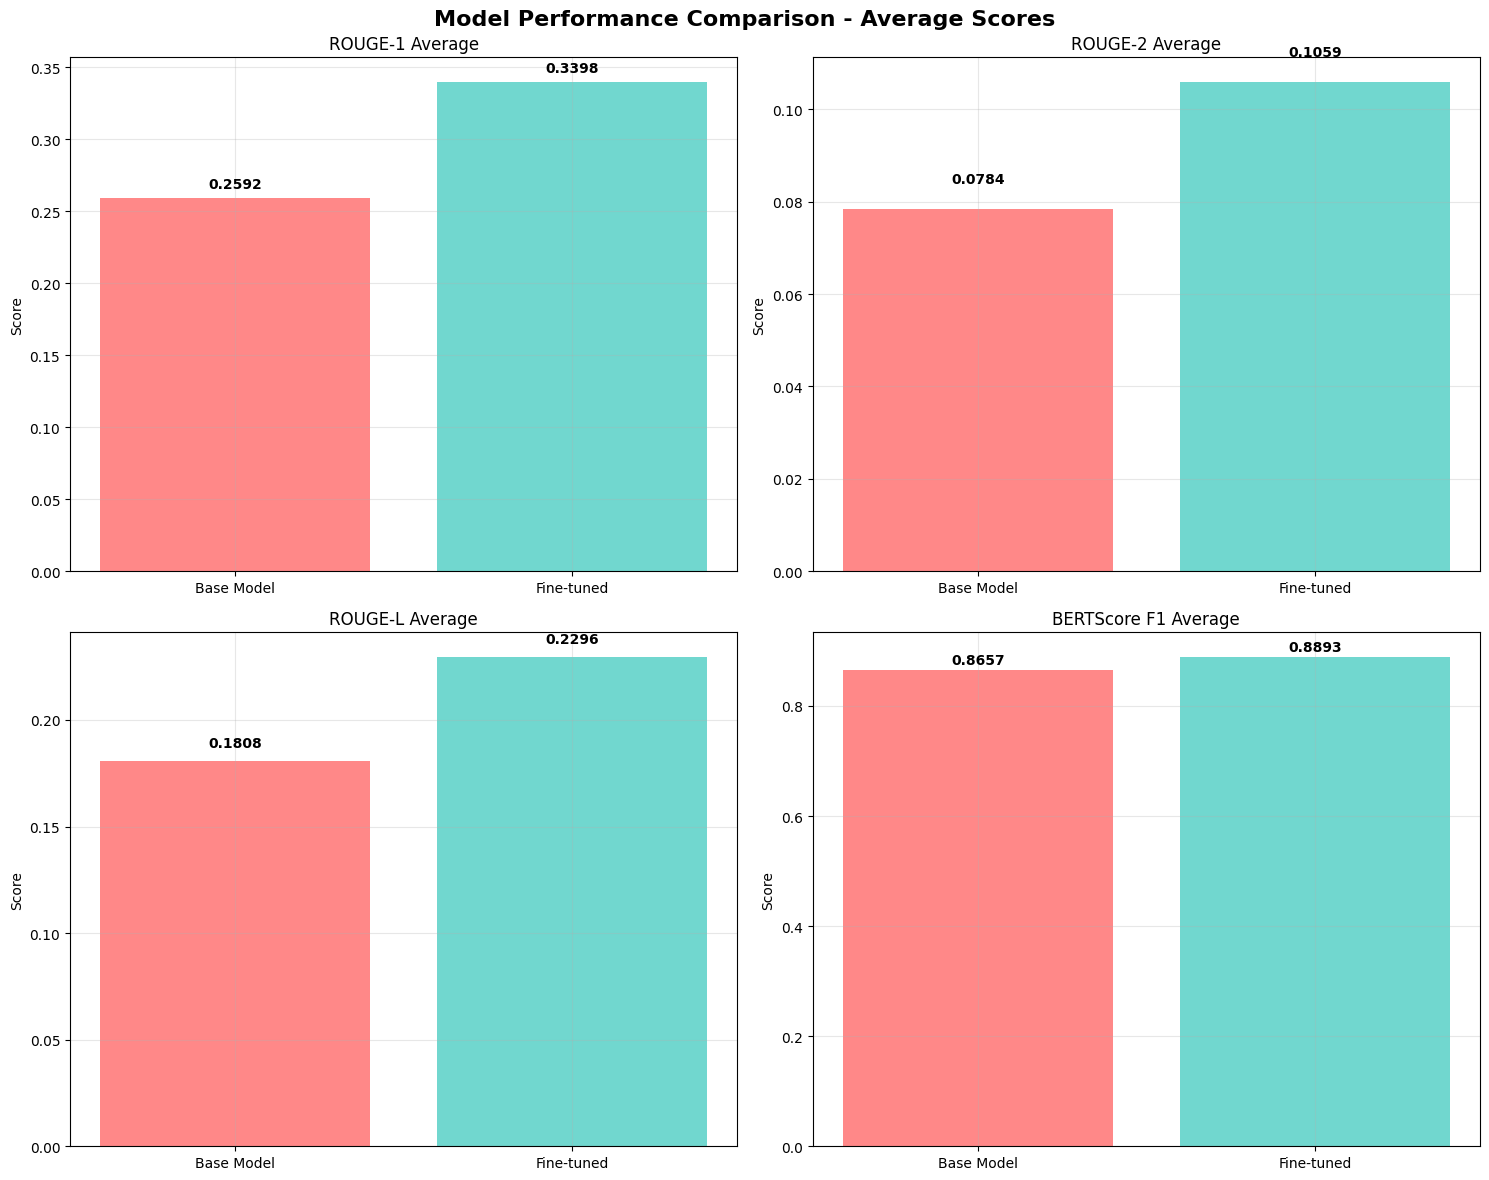

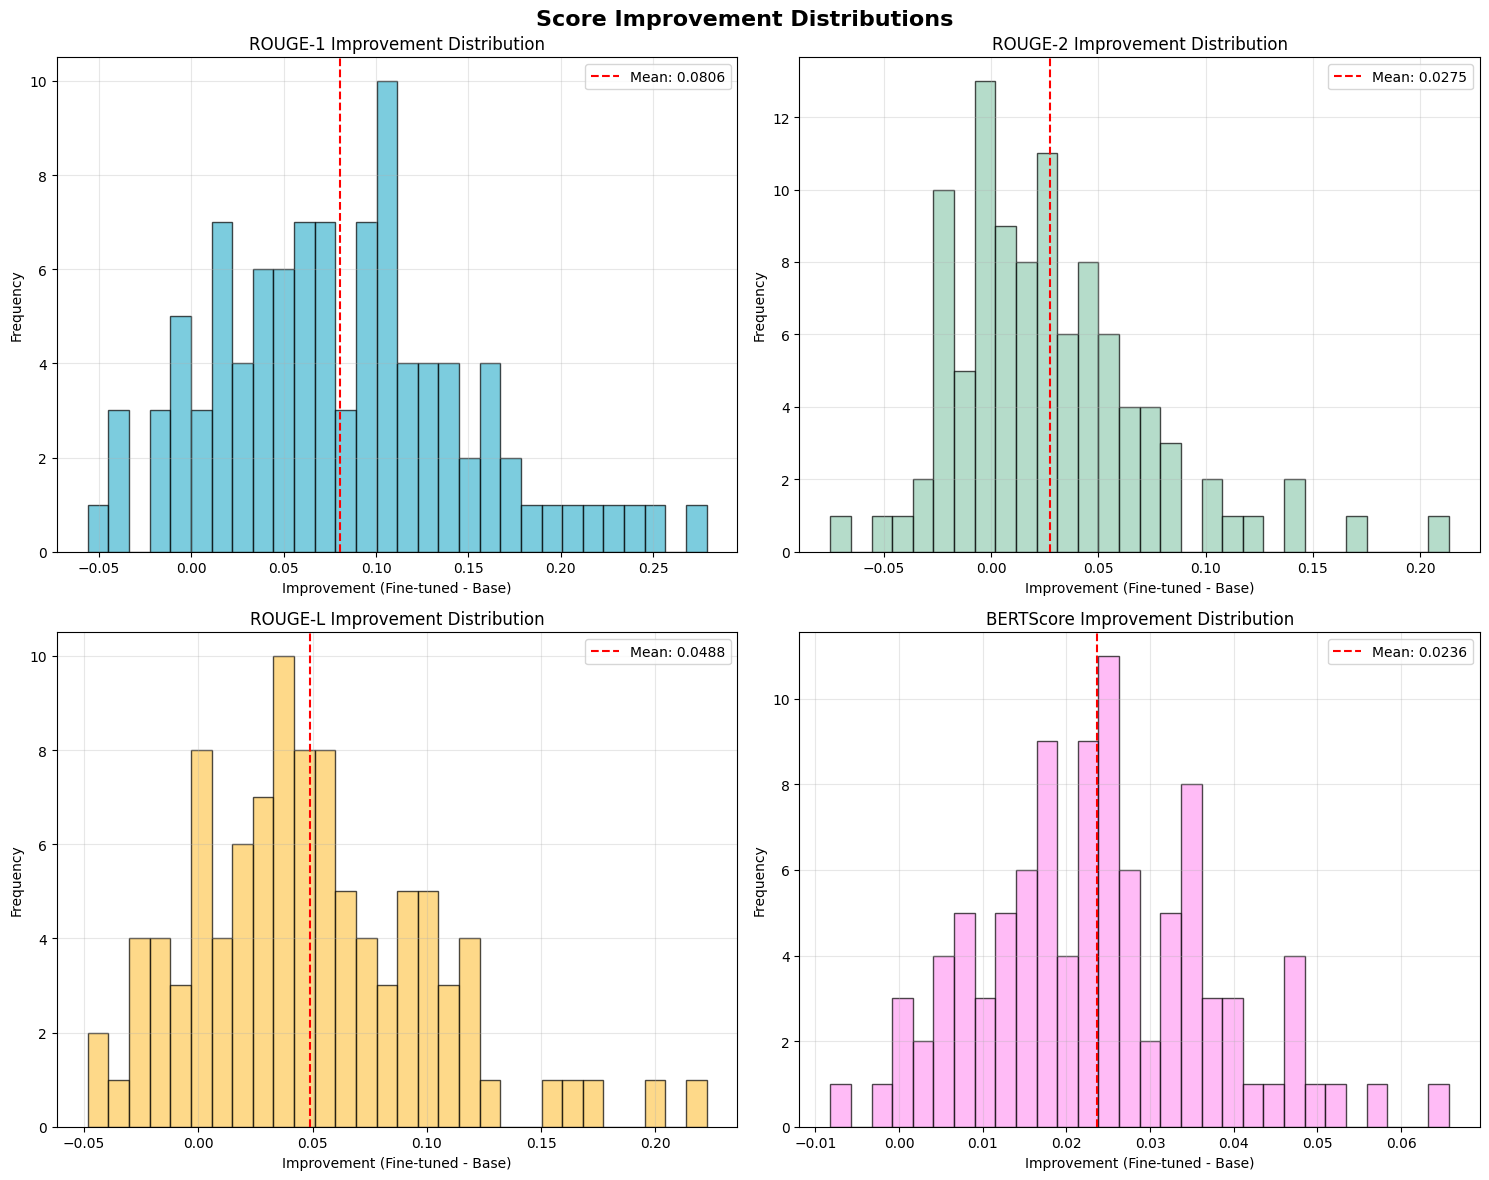

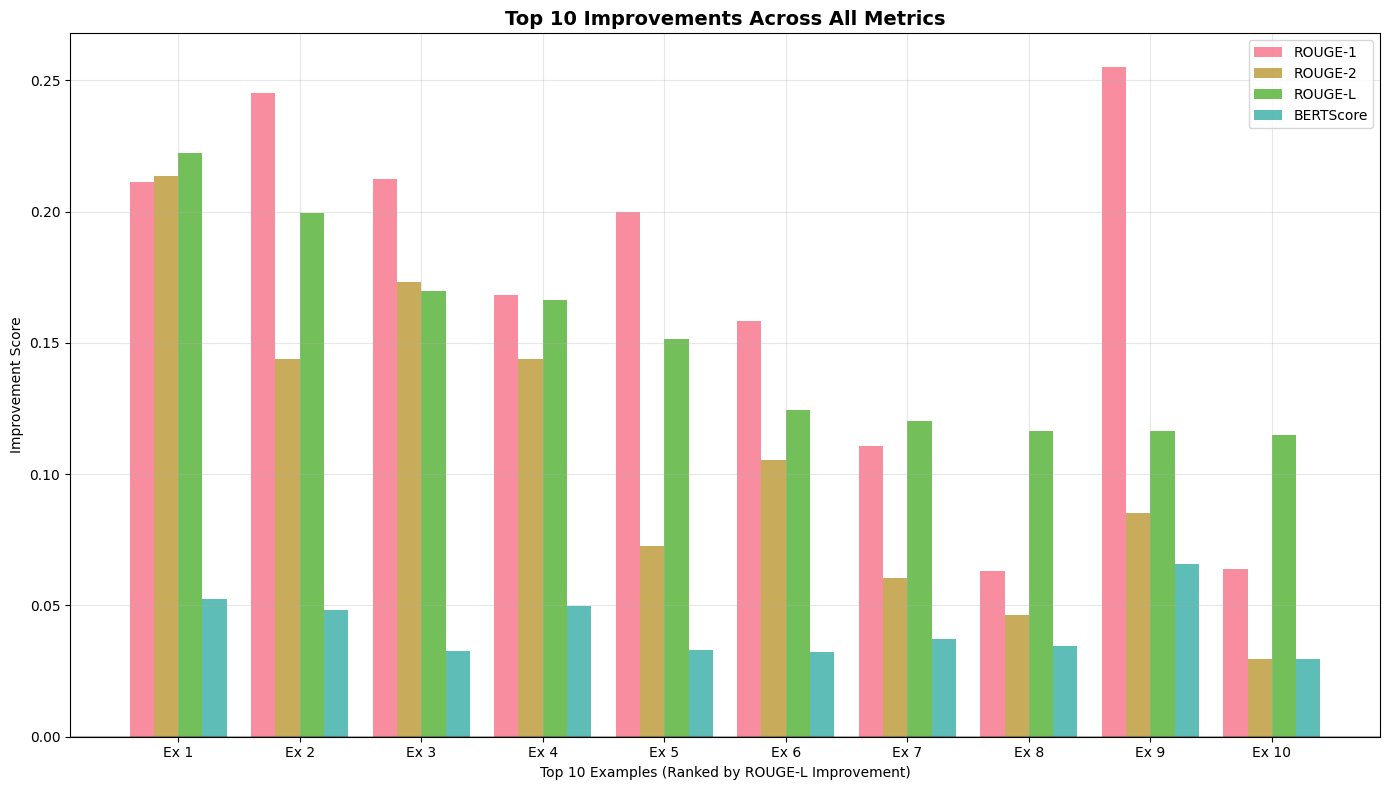

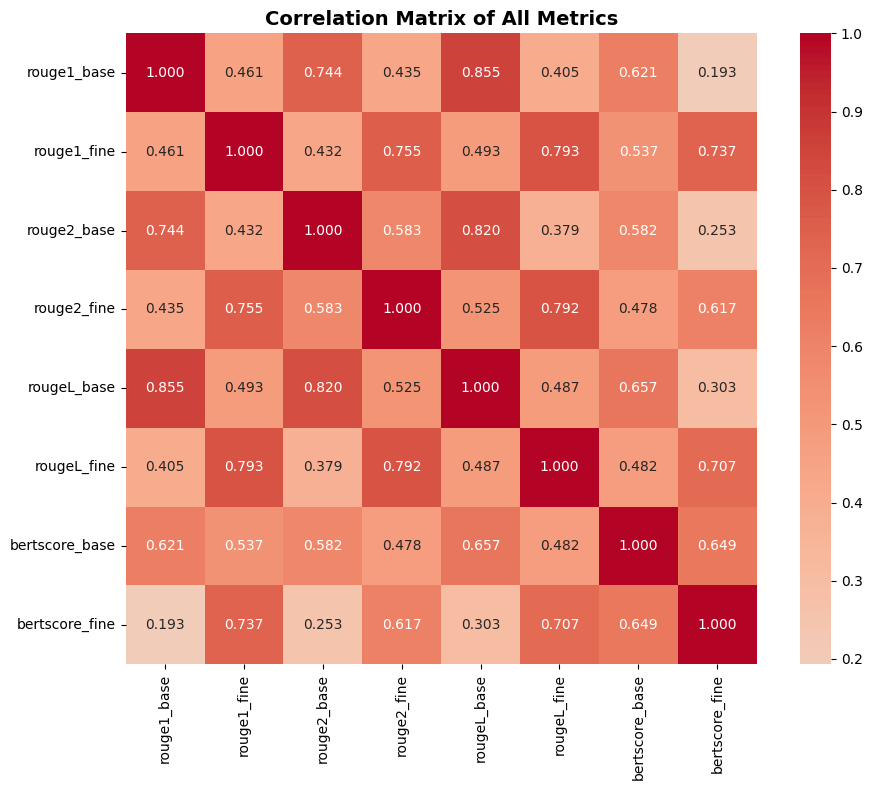

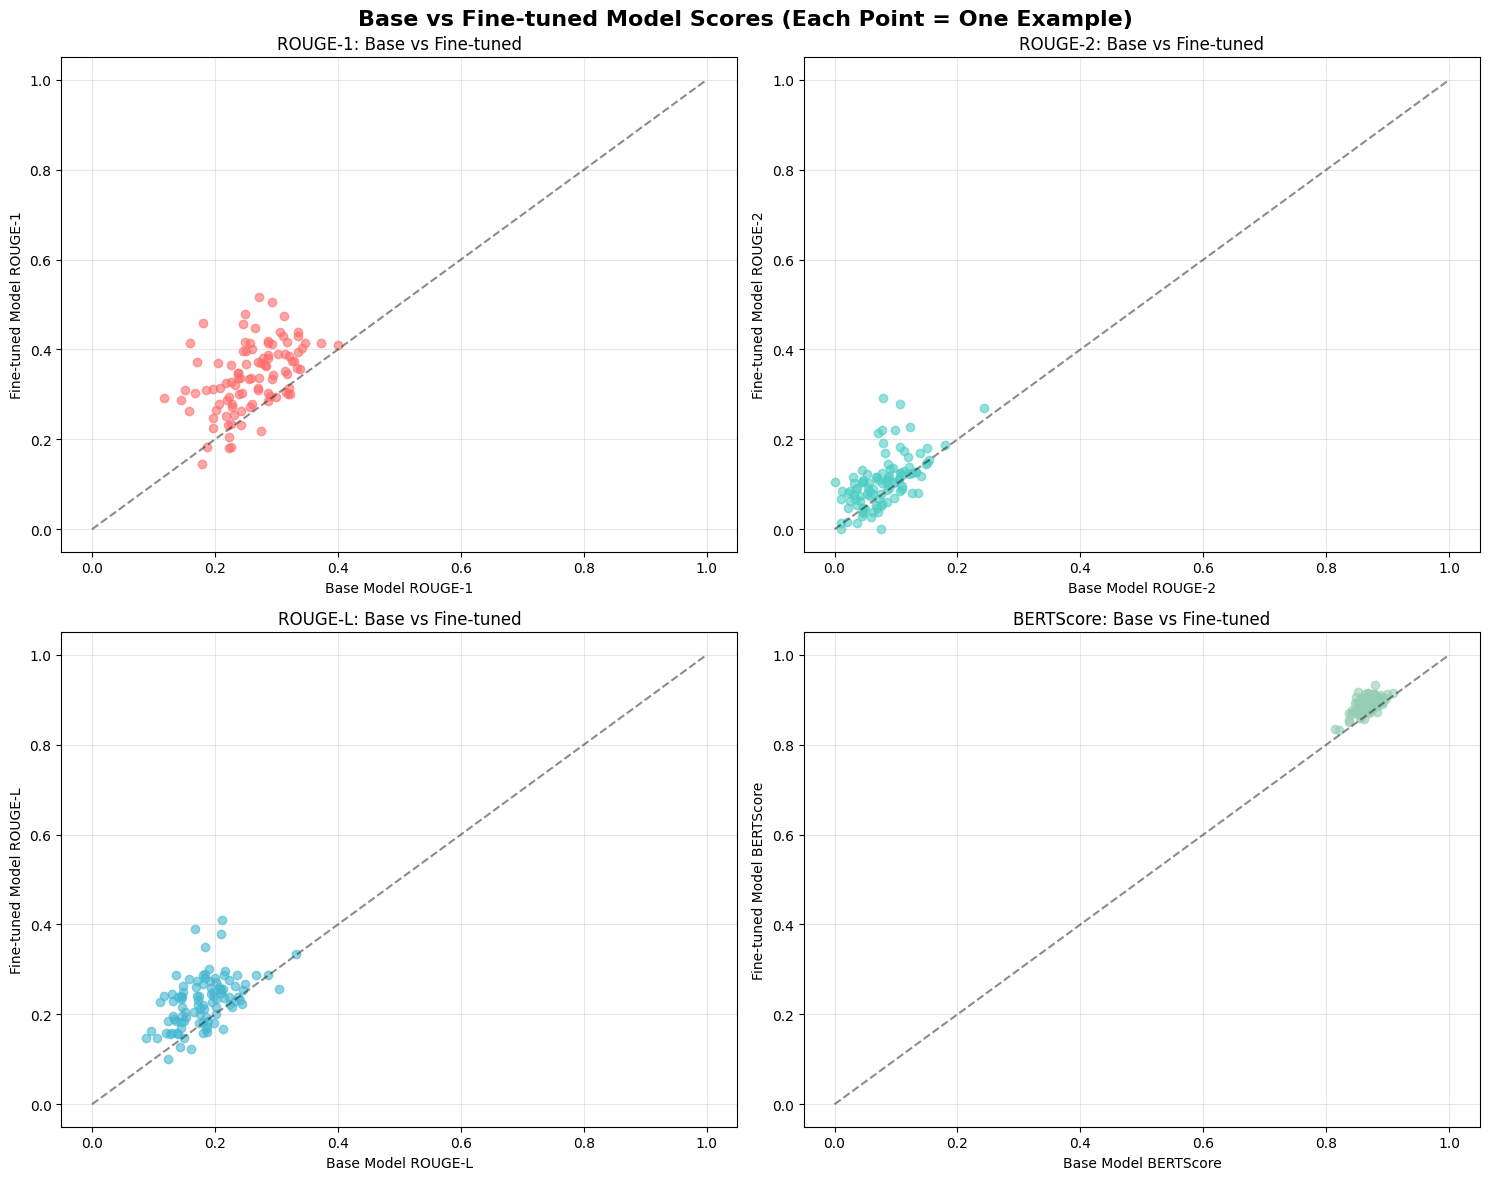

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Convert improvement_data to DataFrame for easier manipulation
df = pd.DataFrame(improvement_data)

print(f"Dataset contains {len(df)} examples")
print(f"Data columns: {df.columns.tolist()}")

# 1. Overall Performance Comparison (Average Scores)
fig1, axes = plt.subplots(2, 2, figsize=(15, 12))
fig1.suptitle('Model Performance Comparison - Average Scores', fontsize=16, fontweight='bold')

# ROUGE-1
ax1 = axes[0, 0]
rouge1_avg = [df['rouge1_base'].mean(), df['rouge1_fine'].mean()]
bars1 = ax1.bar(['Base Model', 'Fine-tuned'], rouge1_avg, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax1.set_title('ROUGE-1 Average')
ax1.set_ylabel('Score')
ax1.grid(True, alpha=0.3)
for i, v in enumerate(rouge1_avg):
    ax1.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# ROUGE-2
ax2 = axes[0, 1]
rouge2_avg = [df['rouge2_base'].mean(), df['rouge2_fine'].mean()]
bars2 = ax2.bar(['Base Model', 'Fine-tuned'], rouge2_avg, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax2.set_title('ROUGE-2 Average')
ax2.set_ylabel('Score')
ax2.grid(True, alpha=0.3)
for i, v in enumerate(rouge2_avg):
    ax2.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# ROUGE-L
ax3 = axes[1, 0]
rougeL_avg = [df['rougeL_base'].mean(), df['rougeL_fine'].mean()]
bars3 = ax3.bar(['Base Model', 'Fine-tuned'], rougeL_avg, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax3.set_title('ROUGE-L Average')
ax3.set_ylabel('Score')
ax3.grid(True, alpha=0.3)
for i, v in enumerate(rougeL_avg):
    ax3.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# BERTScore
ax4 = axes[1, 1]
bert_avg = [df['bertscore_base'].mean(), df['bertscore_fine'].mean()]
bars4 = ax4.bar(['Base Model', 'Fine-tuned'], bert_avg, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax4.set_title('BERTScore F1 Average')
ax4.set_ylabel('Score')
ax4.grid(True, alpha=0.3)
for i, v in enumerate(bert_avg):
    ax4.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Improvement Distribution
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))
fig2.suptitle('Score Improvement Distributions', fontsize=16, fontweight='bold')

# Calculate improvements
df['rouge1_improvement'] = df['rouge1_fine'] - df['rouge1_base']
df['rouge2_improvement'] = df['rouge2_fine'] - df['rouge2_base']
df['rougeL_improvement'] = df['rougeL_fine'] - df['rougeL_base']
df['bertscore_improvement'] = df['bertscore_fine'] - df['bertscore_base']

# ROUGE-1 improvement histogram
ax1 = axes[0, 0]
ax1.hist(df['rouge1_improvement'], bins=30, alpha=0.7, color='#45B7D1', edgecolor='black')
ax1.axvline(df['rouge1_improvement'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["rouge1_improvement"].mean():.4f}')
ax1.set_title('ROUGE-1 Improvement Distribution')
ax1.set_xlabel('Improvement (Fine-tuned - Base)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ROUGE-2 improvement histogram
ax2 = axes[0, 1]
ax2.hist(df['rouge2_improvement'], bins=30, alpha=0.7, color='#96CEB4', edgecolor='black')
ax2.axvline(df['rouge2_improvement'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["rouge2_improvement"].mean():.4f}')
ax2.set_title('ROUGE-2 Improvement Distribution')
ax2.set_xlabel('Improvement (Fine-tuned - Base)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ROUGE-L improvement histogram
ax3 = axes[1, 0]
ax3.hist(df['rougeL_improvement'], bins=30, alpha=0.7, color='#FECA57', edgecolor='black')
ax3.axvline(df['rougeL_improvement'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["rougeL_improvement"].mean():.4f}')
ax3.set_title('ROUGE-L Improvement Distribution')
ax3.set_xlabel('Improvement (Fine-tuned - Base)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

# BERTScore improvement histogram
ax4 = axes[1, 1]
ax4.hist(df['bertscore_improvement'], bins=30, alpha=0.7, color='#FF9FF3', edgecolor='black')
ax4.axvline(df['bertscore_improvement'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["bertscore_improvement"].mean():.4f}')
ax4.set_title('BERTScore Improvement Distribution')
ax4.set_xlabel('Improvement (Fine-tuned - Base)')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Top 10 Improvements Visualization
fig3, ax = plt.subplots(figsize=(14, 8))

# Get top 10 improvements (already sorted in your code)
top_10_df = df.nlargest(10, 'delta_rougeL')

x = range(10)
width = 0.2

# Create grouped bar chart for top 10
rouge1_improvements = top_10_df['rouge1_improvement'].values
rouge2_improvements = top_10_df['rouge2_improvement'].values
rougeL_improvements = top_10_df['rougeL_improvement'].values
bert_improvements = top_10_df['bertscore_improvement'].values

ax.bar([i - 1.5*width for i in x], rouge1_improvements, width, label='ROUGE-1', alpha=0.8)
ax.bar([i - 0.5*width for i in x], rouge2_improvements, width, label='ROUGE-2', alpha=0.8)
ax.bar([i + 0.5*width for i in x], rougeL_improvements, width, label='ROUGE-L', alpha=0.8)
ax.bar([i + 1.5*width for i in x], bert_improvements, width, label='BERTScore', alpha=0.8)

ax.set_xlabel('Top 10 Examples (Ranked by ROUGE-L Improvement)')
ax.set_ylabel('Improvement Score')
ax.set_title('Top 10 Improvements Across All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Ex {i+1}' for i in range(10)])
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Correlation Matrix
fig4, ax = plt.subplots(figsize=(10, 8))

# Create correlation matrix of all metrics
correlation_cols = ['rouge1_base', 'rouge1_fine', 'rouge2_base', 'rouge2_fine',
                   'rougeL_base', 'rougeL_fine', 'bertscore_base', 'bertscore_fine']
corr_matrix = df[correlation_cols].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=ax, fmt='.3f')
ax.set_title('Correlation Matrix of All Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Scatter Plot: Base vs Fine-tuned
fig5, axes = plt.subplots(2, 2, figsize=(15, 12))
fig5.suptitle('Base vs Fine-tuned Model Scores (Each Point = One Example)', fontsize=16, fontweight='bold')

# ROUGE-1 scatter
ax1 = axes[0, 0]
ax1.scatter(df['rouge1_base'], df['rouge1_fine'], alpha=0.6, color='#FF6B6B')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # diagonal line
ax1.set_xlabel('Base Model ROUGE-1')
ax1.set_ylabel('Fine-tuned Model ROUGE-1')
ax1.set_title('ROUGE-1: Base vs Fine-tuned')
ax1.grid(True, alpha=0.3)

# ROUGE-2 scatter
ax2 = axes[0, 1]
ax2.scatter(df['rouge2_base'], df['rouge2_fine'], alpha=0.6, color='#4ECDC4')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('Base Model ROUGE-2')
ax2.set_ylabel('Fine-tuned Model ROUGE-2')
ax2.set_title('ROUGE-2: Base vs Fine-tuned')
ax2.grid(True, alpha=0.3)

# ROUGE-L scatter
ax3 = axes[1, 0]
ax3.scatter(df['rougeL_base'], df['rougeL_fine'], alpha=0.6, color='#45B7D1')
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('Base Model ROUGE-L')
ax3.set_ylabel('Fine-tuned Model ROUGE-L')
ax3.set_title('ROUGE-L: Base vs Fine-tuned')
ax3.grid(True, alpha=0.3)

# BERTScore scatter
ax4 = axes[1, 1]
ax4.scatter(df['bertscore_base'], df['bertscore_fine'], alpha=0.6, color='#96CEB4')
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_xlabel('Base Model BERTScore')
ax4.set_ylabel('Fine-tuned Model BERTScore')
ax4.set_title('BERTScore: Base vs Fine-tuned')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Highlights

- Fine-tuned TinyLlama-1.1B-Chat using Parameter-Efficient Fine-Tuning with LoRA and 4-bit quantization to adapt the model to the marine biology domain with minimal compute and memory overhead.

- Only 1.13% of model parameters (~12.6M) were updated, enabling low-resource fine-tuning on consumer GPUs while preserving the base model's general capabilities.

- A new instruction-style Q&A dataset was created for the marine biology domain, addressing a previously unmet need for such domain-specific instruction tuning data.

- Demonstrated the capability of pretrained LLMs to generate high-quality synthetic datasets—enabling bootstrapping of instruction-tuning tasks in data-scarce domains.

- Instruction fine-tuning was performed on 900 synthetic examples (from a dataset of 1000), formatted using <|user|> and <|assistant|> tokens to simulate multi-turn dialogue. The remaining 100 examples were held out for evaluation.

- Quantitative improvements were observed across lexical overlap, semantic similarity, and answer span matching metrics. The fine-tuned model produced more focused, specific answers compared to the broader responses of the base model—highlighting the effectiveness of targeted fine-tuning and the strong prior knowledge in pretrained LLMs.

- Emergent generalization: The fine-tuned model exhibited more precise use of marine biology terminology and structure, despite the low-data setting, while the base model, without any domain-specific supervision, produced broader but coherent responses—highlighting the strong general knowledge embedded in pretrained LLMs.

- Validates that pretrained LLMs encode broad, transferable knowledge. With techniques like LoRA, they can be efficiently adapted to specialized domains—demonstrating the strength of transfer learning in modern NLP.


## References

1. [Marine Biology Q&A Dataset – Hugging Face](https://huggingface.co/datasets/enigma04/marine-biology-qna-dataset)
2. [TinyLlama-1.1B-Chat-v1.0 – Hugging Face](https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0)  
3. [PEFT Documentation – Hugging Face](https://huggingface.co/docs/peft/index)  
4. [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)  
5. [Parameter-Efficient Fine-Tuning Methods – Hugging Face Blog](https://huggingface.co/blog/peft)  
6. [Evaluating Large Language Models](https://arxiv.org/abs/2307.03109)  
7. [Gemini API: GenerationConfig Documentation](https://ai.google.dev/api/generate-content#v1beta.GenerationConfig)  
8. [Gemini API: Text Generation Guide](https://ai.google.dev/gemini-api/docs/text-generation)